# Optimized Moving Median Filter   
### Using Min/Max Heap with Static Memory Allocation

Kostadin Bajalcaliev, Index: 239038

### Problem

In ECG signal processing, the first step is to remove noise, such as high-frequency powerline interference (50/60 Hz) and low-frequency baseline wander. While band-pass filtering is a common solution, and Butterworth filters are frequently preferred, they require forward-backward filtering to eliminate phase distortion. This not only doubles the computational load but also introduces critical latency in real-time applications. 

### Discussion

Baseline wander is typically handled using high-pass filters with cutoff frequencies ranging from 0.5 Hz to 1 Hz. Caused by factors such as respiration, electrode motion, and patient movement, it is non-stationary and lacks a predictable frequency profile. This artifact can significantly degrade ECG signal quality, which particularly impacts the detection and delineation of low-amplitude, low-frequency features like the P-wave and T-wave. Accurate detection of these features is dependent on a precise estimation of the isoelectric line.

An alternative approach is the use of median filters. These non-linear filters replace each sample with the median value within a sliding window. This approach is less sensitive to outliers and preserves the shape of the ECG waveform, without introducing phase distortion, making them suitable for real-time applications. However, the frequency response of median filters is complex and not as well-defined as that of linear filters. This makes it challenging to predict their effect on the ECG signal, especially in patients with a complex interplay of arrhythmias or other abnormalities.

The use of longer window sizes can improve the characteristics of the median filter, making it less likely to treat exceptionally wide or distorted QRS morphologies as baseline wander. Combining a median filter with a low-pass Lynn filter results in more effective baseline wander removal. This hybrid approach achieves a frequency response similar to that of the Lynn filter alone while leveraging the advantages of the median filter. However, this comes at the cost of increased computational complexity and memory usage. 

The naive sort-based implementation of a median filter has a time complexity of O(N log N) per sample, which is problematic for real-time applications, especially with longer window sizes. Using min/max heaps can reduce this to O(log N) per sample. However, the sliding window requires the removal of outgoing samples, an operation not natively supported by heaps. To address this, a lazy deletion strategy can be employed, where samples are marked for deletion and only removed when they reach the top of the heap. This strategy introduces additional memory overhead due to dynamic memory allocation. In the worst case, some samples may remain in the heap for extended periods before being deleted, or even indefinitely.

### Implementation

Use of static memory allocation is highly desirable for real-time and embedded applications, pre-allocating memory for the maximum number of samples that can be in the heaps at any given time. Removal of outgoing samples now requires searching the heaps and rebalancing them, before inserting the incoming sample. As the median is always at the root of one of the heaps, it only required to search one of the heaps, half the window size, resulting in time complexity O(N log N). The element to be removed is more likely to be towards the bottom of the heap, experiments showed that searching in reverse order results in faster average search. Compared to the naive sort-based implementation, this approach reduces the computing time up to 30%-40% for window sizes in the range of 500-600 ms. Additional benefit is that min/max heap approach can elegantly handle dymamic window sizes, computing the median of measurments in a fixed time window instead of a fixed number of successive samples covering varying time spans.

Static memory allocation is highly desirable for real-time and embedded applications. This involves pre-allocating memory for the maximum number of samples the heaps can contain. To process a new sample, the outgoing sample must first be located and removed from its heap, requiring a search and rebalancing operation, before the incoming sample is inserted. Since the median is always at the root of one of the heaps, only one heap needs to be searched. This results in a worst-case time complexity of O(N). Empirical testing showed that searching the heap in reverse order (from the last leaf node upwards) yields a faster average search time, as the element to be removed is statistically more likely to be located near the bottom.

Compared to the naive sort-based implementation, this heap-based approach with static allocation reduces computing time by 30% to 40% for window sizes corresponding to 500-600 ms at 250 Hz. An additional benefit is that the min/max heap approach can elegantly handle dynamic window sizes, calculating the median over a fixed time window rather than a fixed number of successive samples, which can cover varying time spans.

### Figures

The provided strips display two minutes of signal from the MIT-BIH record 101, sampled at 250 Hz and contaminated with both high-frequency noise and baseline wander. A third-order Butterworth band-pass filter (0.5-25 Hz) serves as the reference.

- Top (Black): The raw signal. The green line represents the isoelectric line estimated by the Median+Lynn filter approach.
- Middle (Dark Blue): The signal after baseline wander removal, followed by adaptive low-pass filtering.
- Bottom (Red): The signal processed with the Butterworth band-pass filter, applied in a zero-phase manner using forward and backward passes on 1000 ms segments with a 500 ms overlap.
- Last (Brown): The signal processed with a forward-pass-only Butterworth band-pass filter, clearly demonstrating the effects of phase distortion.

The use of any linear low-pass filter can affect the amplitudes of QRS complexes, particularly when the cutoff frequency is near their dominant spectral components. This amplitude attenuation can lead to an underestimation of QRS amplitude and alter the relative amplitudes of the P and T waves, potentially impacting clinical interpretation. To mitigate this, the middle (dark blue) signal is a result of an adaptive filtering technique designed to preserve the high-frequency QRS complexes.

Conceptually, this technique combines a primary Savitzky–Golay filter with a secondary low-pass Lynn filter. The resulting filtered signals are merged using a Kaiser–Bessel-derived window as a weighting function, centered on the QRS complexes. The detailed description of this method is beyond the scope of this document.


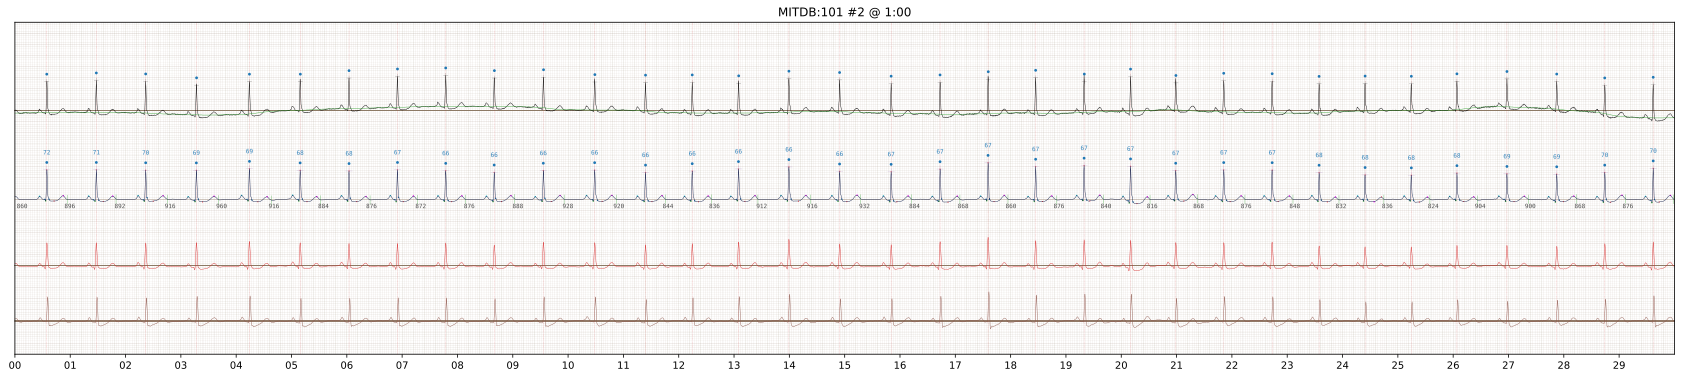

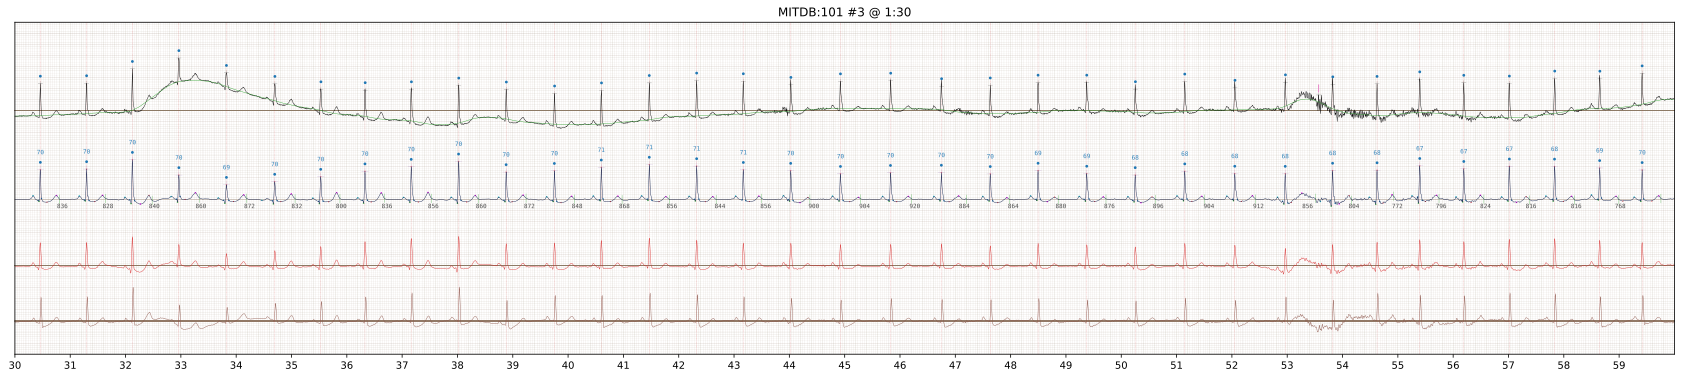

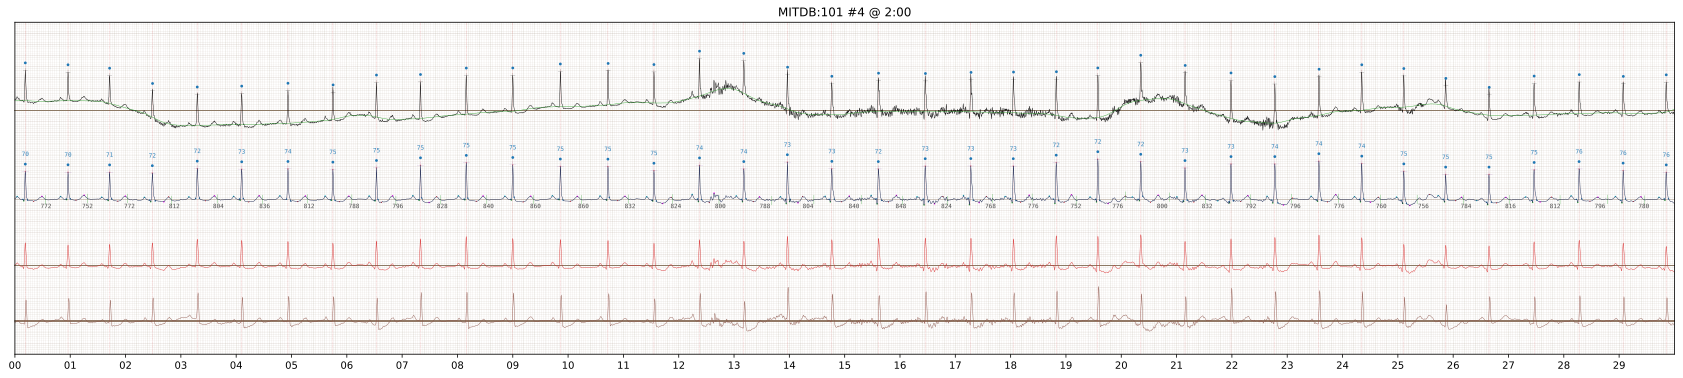

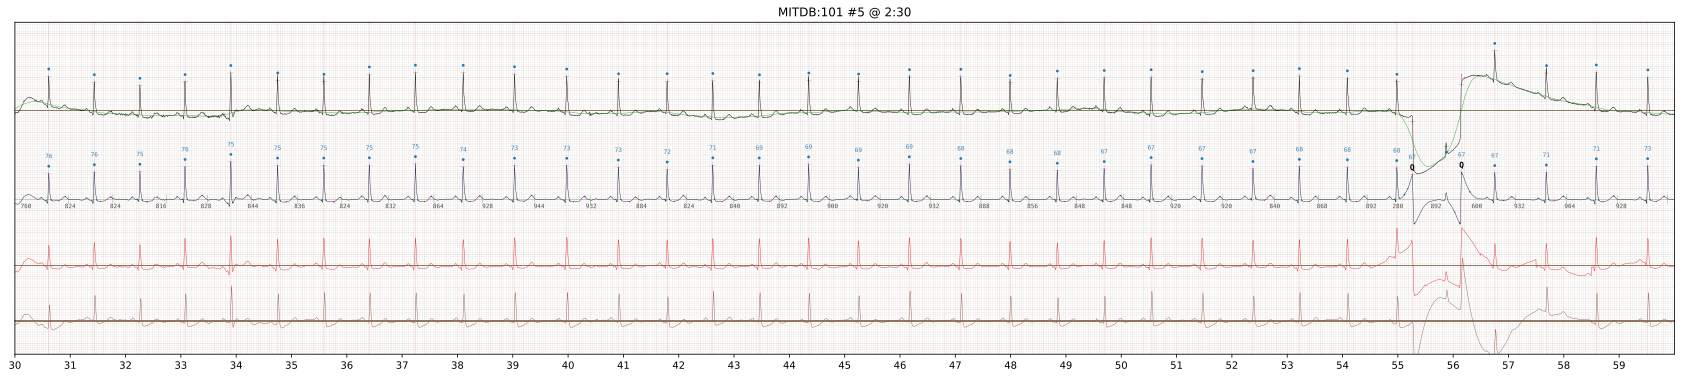

In [6]:
import dbx
%config InlineBackend.figure_format = 'svg'
dbx.Plot("MITDB", "101", pages = [2,3,4,5])

## CPU Profiling

> Profiling data indicates that the Median Filter accounts for significant CPU usage,  
> highlighting the importance of optimizing this specific component in the processing pipeline.

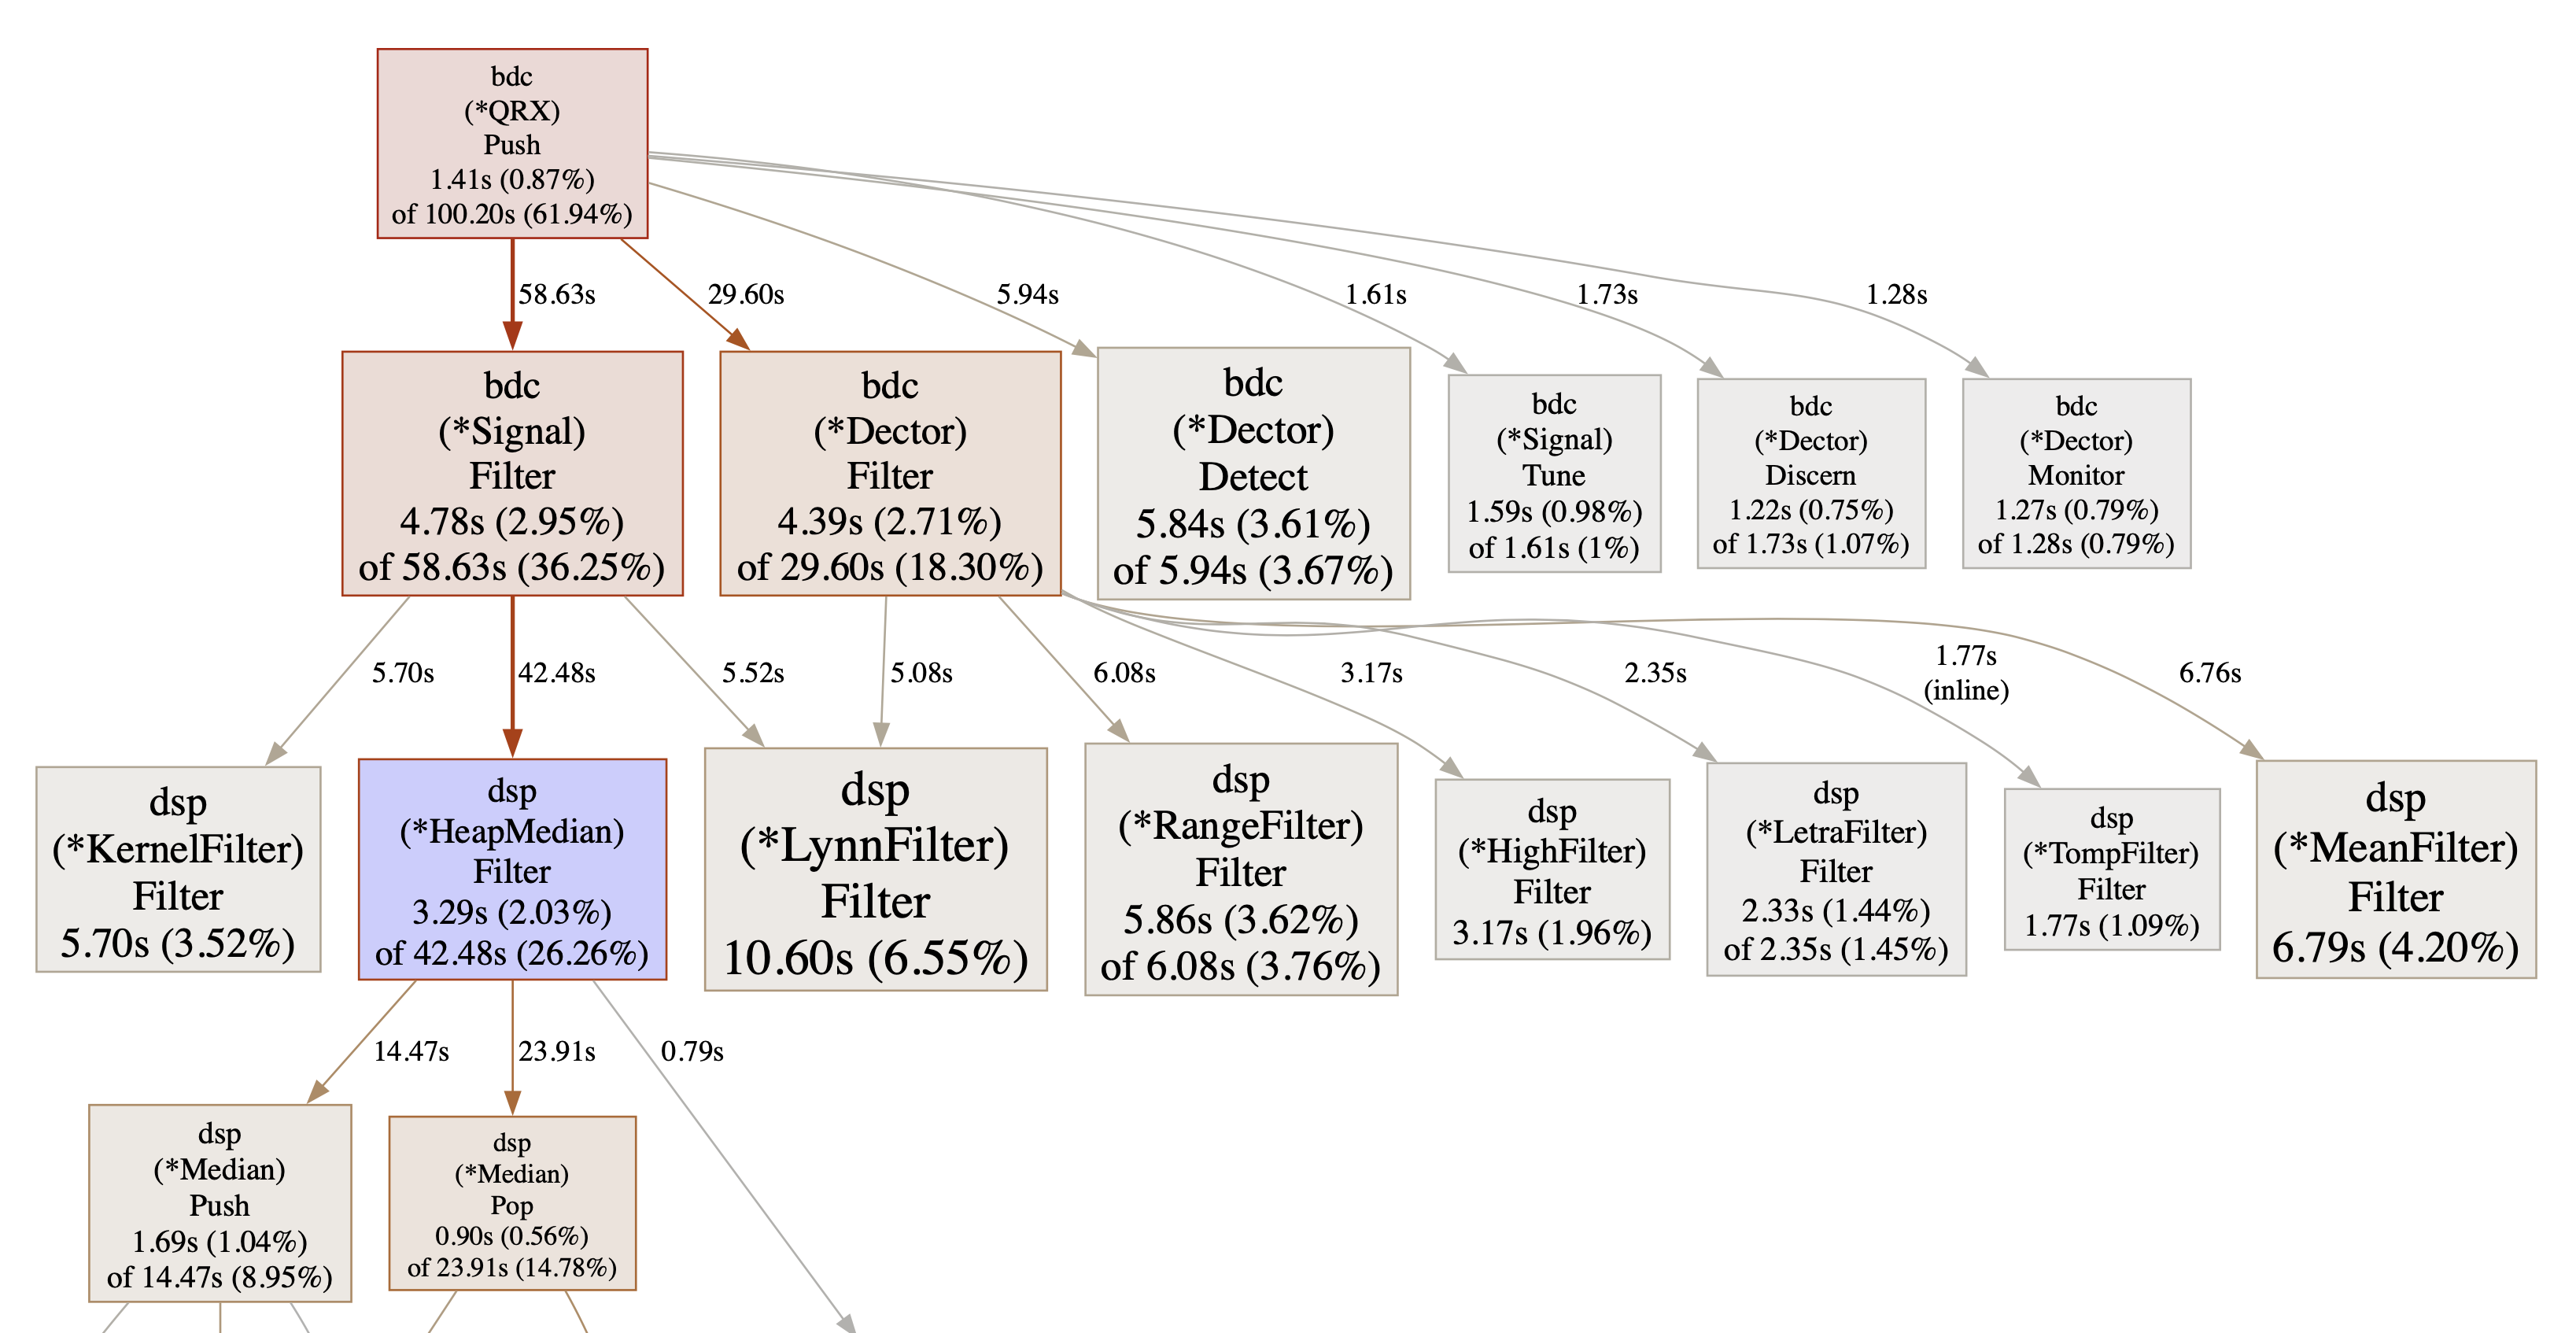

### Naive Sort Approach

### Mix/Max Heap Approach

### Test Code

### Example Execution

In [ ]:
## GO #################################

$ go run cmd/test.go

Median random test passed
SortMedian took: 2977968
HeapMedian took: 1907521
Heap/Sort = -35.946%

## Java ###############################

$ cd java
$ javac SortMedian.java Heap.java HeapMedian.java MedianTest.java
$ java MedianTest

Median random test passed
SortMedian took: 1722689
HeapMedian took: 1559468
Heap/Sort = -9.475%